Copyright (c) 2015-2017 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 2 - Training Machine Learning Algorithms for Classification

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -p numpy,pandas,matplotlib

Sebastian Raschka 
last updated: 2017-03-10 

numpy 1.12.0
pandas 0.19.2
matplotlib 2.0.0


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview


- [Artificial neurons - a brief glimpse into the early history
of machine learning](#Artificial-neurons-a-brief-glimpse-into-the-early-history-of-machine-learning)
- [Implementing a perceptron learning algorithm in Python](#Implementing-a-perceptron-learning-algorithm-in-Python)
    - [Training a perceptron model on the Iris dataset](#Training-a-perceptron-model-on-the-Iris-dataset)
- [Adaptive linear neurons and the convergence of learning](#Adaptive-linear-neurons-and-the-convergence-of-learning)
    - [Minimizing cost functions with gradient descent](#Minimizing-cost-functions-with-gradient-descent)
    - [Implementing an Adaptive Linear Neuron in Python](#Implementing-an-Adaptive-Linear-Neuron-in-Python)
    - [Large scale machine learning and stochastic gradient descent](#Large-scale-machine-learning-and-stochastic-gradient-descent)
- [Summary](#Summary)

<br>
<br>

In [2]:
from IPython.display import Image

# Artificial neurons - a brief glimpse into the early history of machine learning

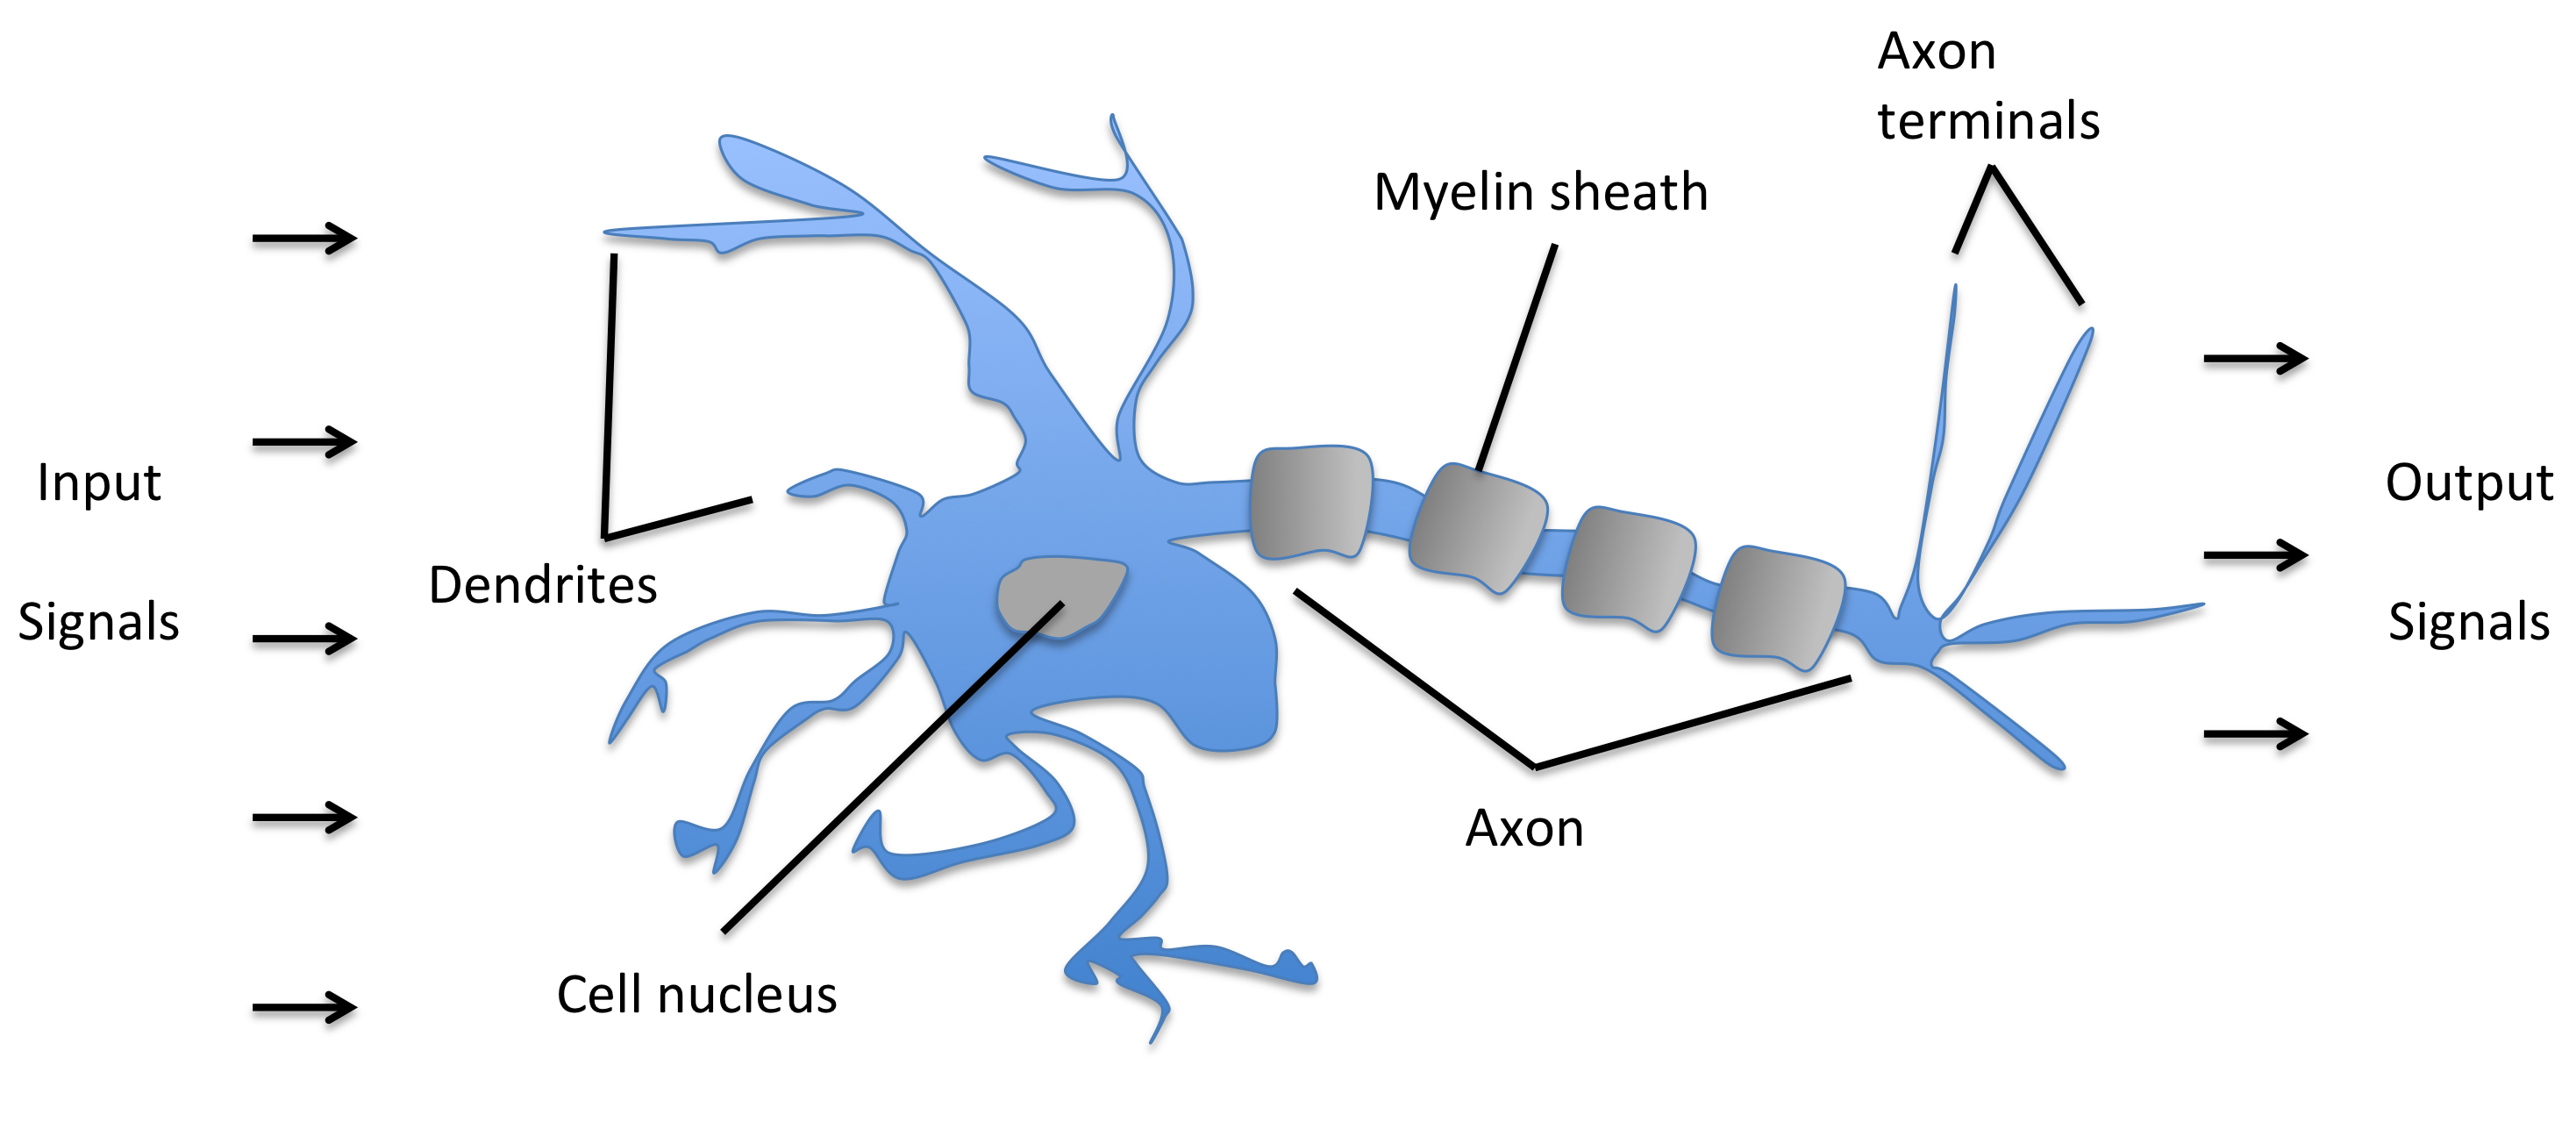

In [3]:
Image(filename='./images/02_01.png', width=500) 

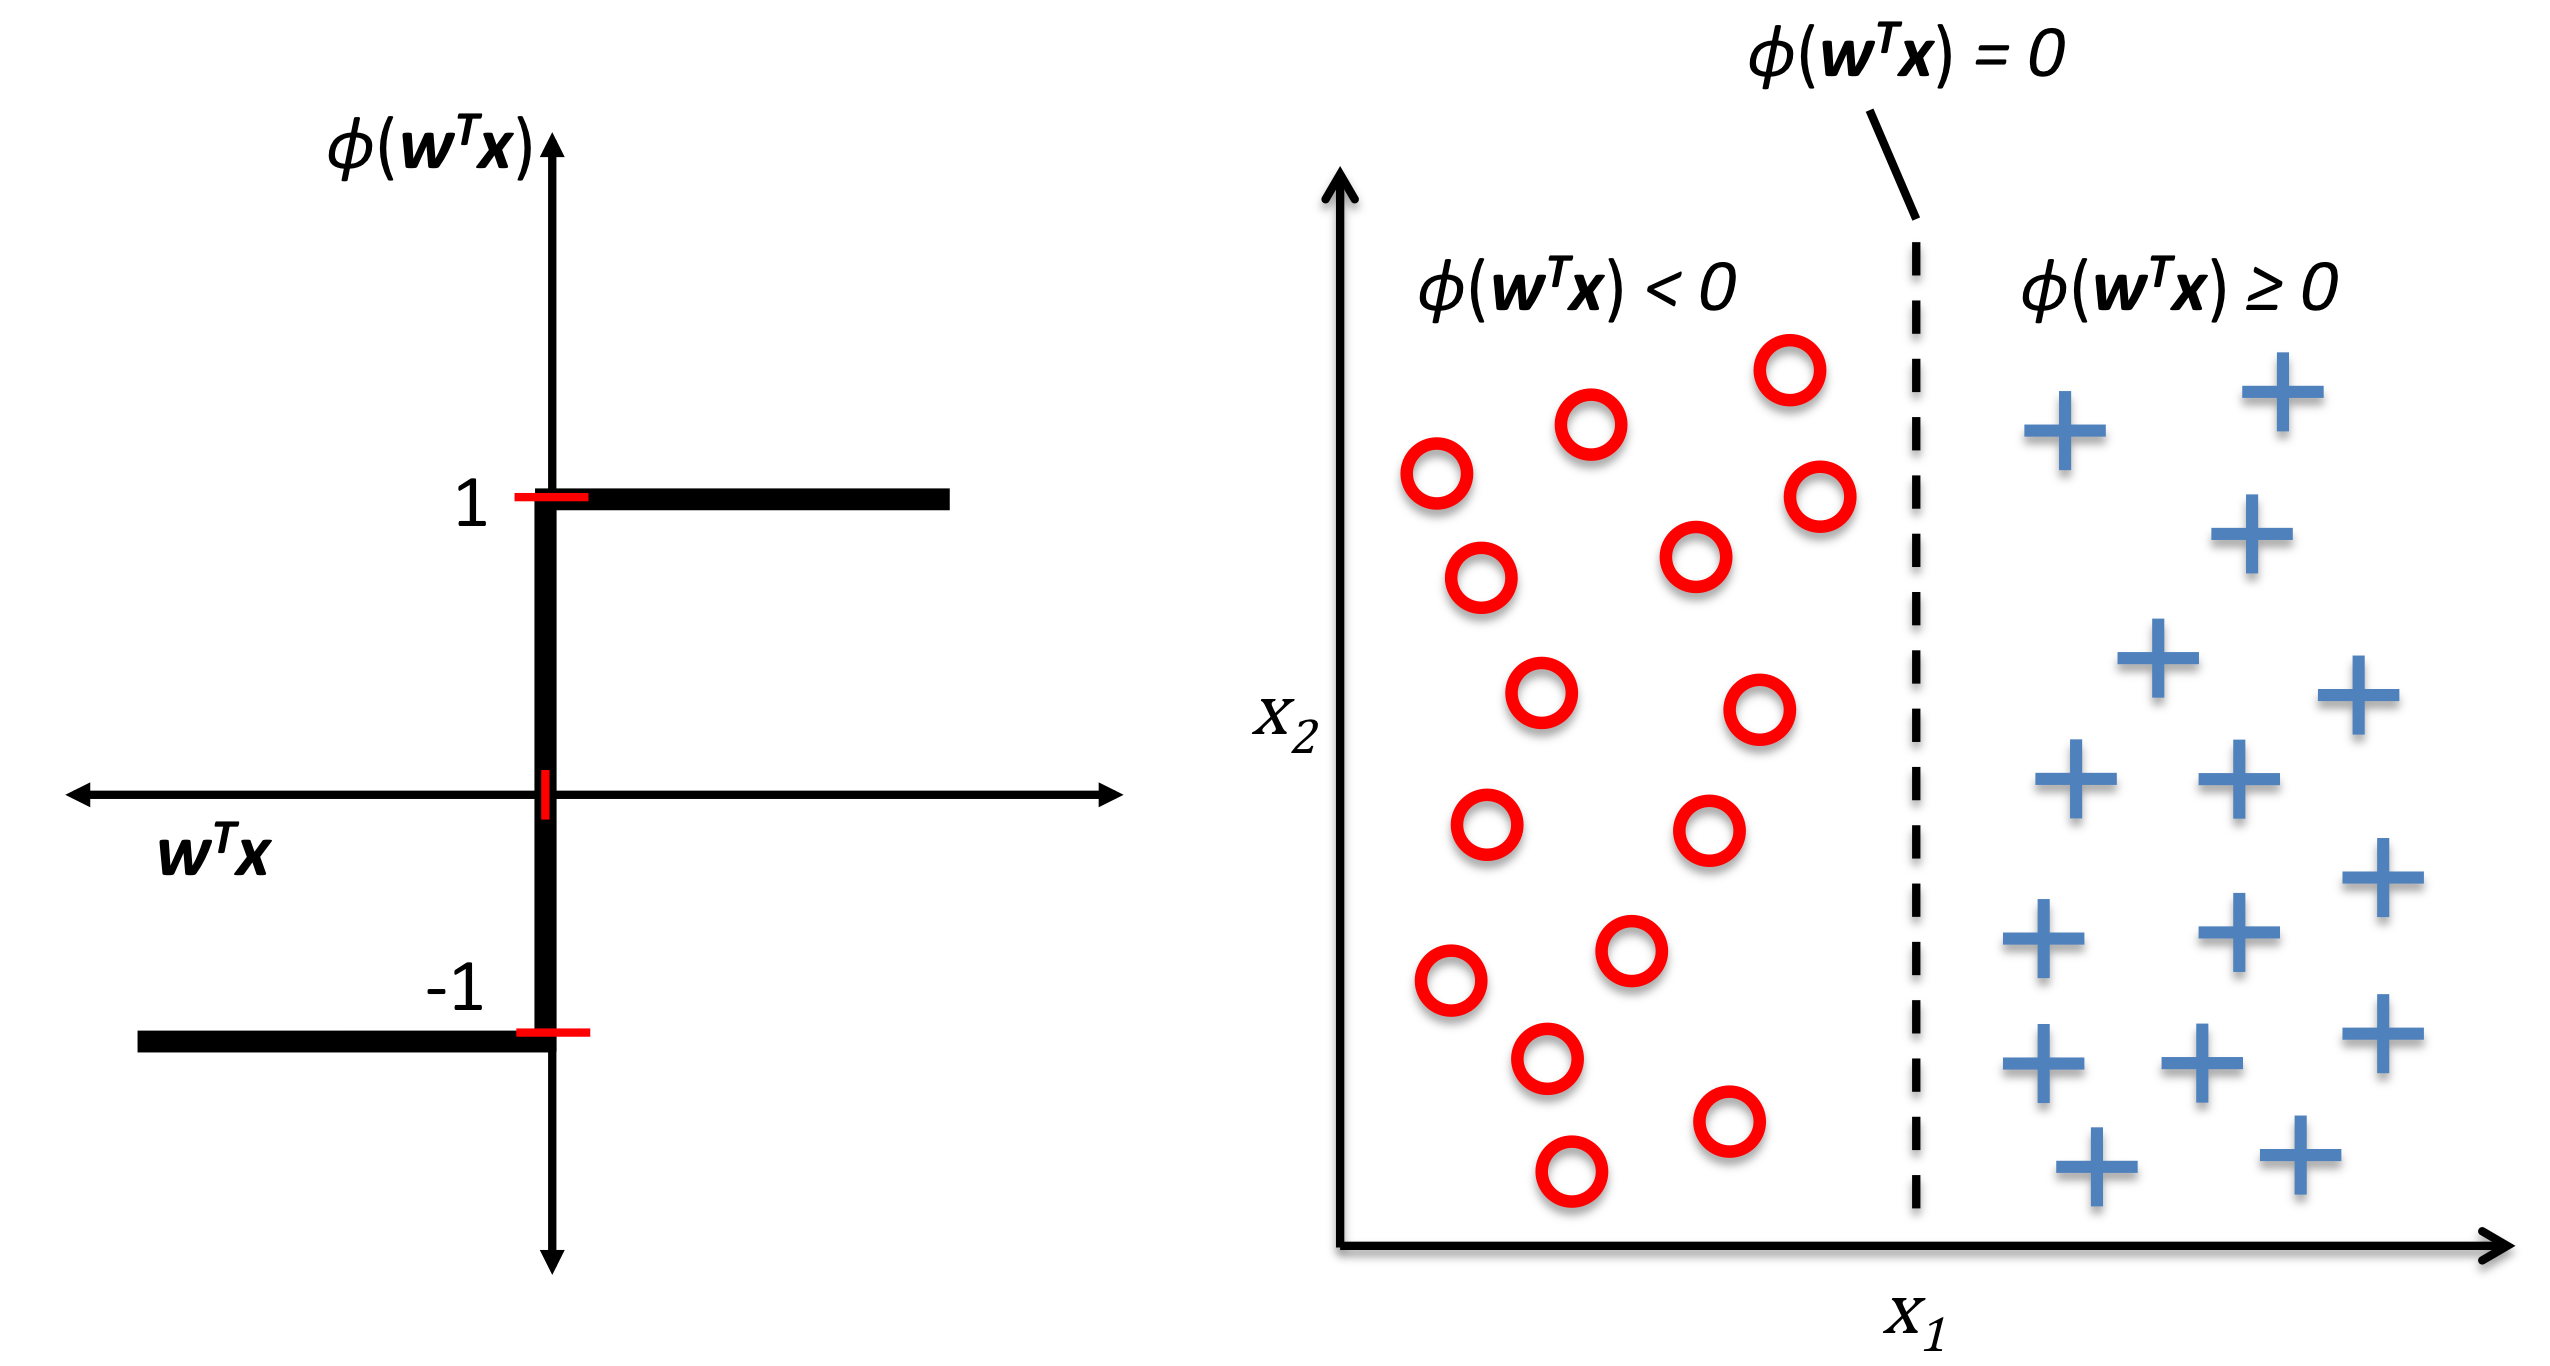

In [4]:
Image(filename='./images/02_02.png', width=500) 

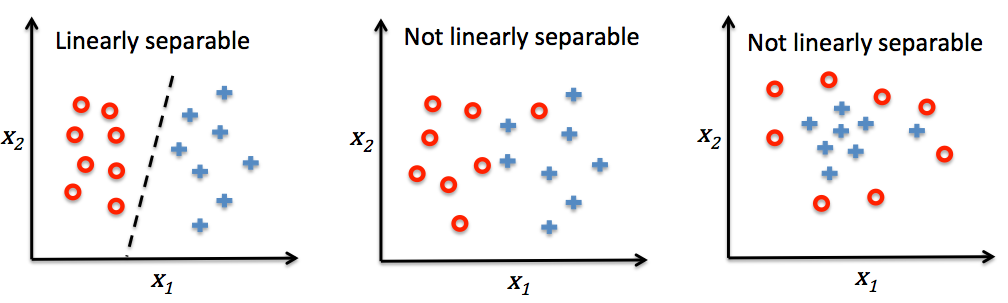

In [5]:
Image(filename='./images/02_03.png', width=600) 

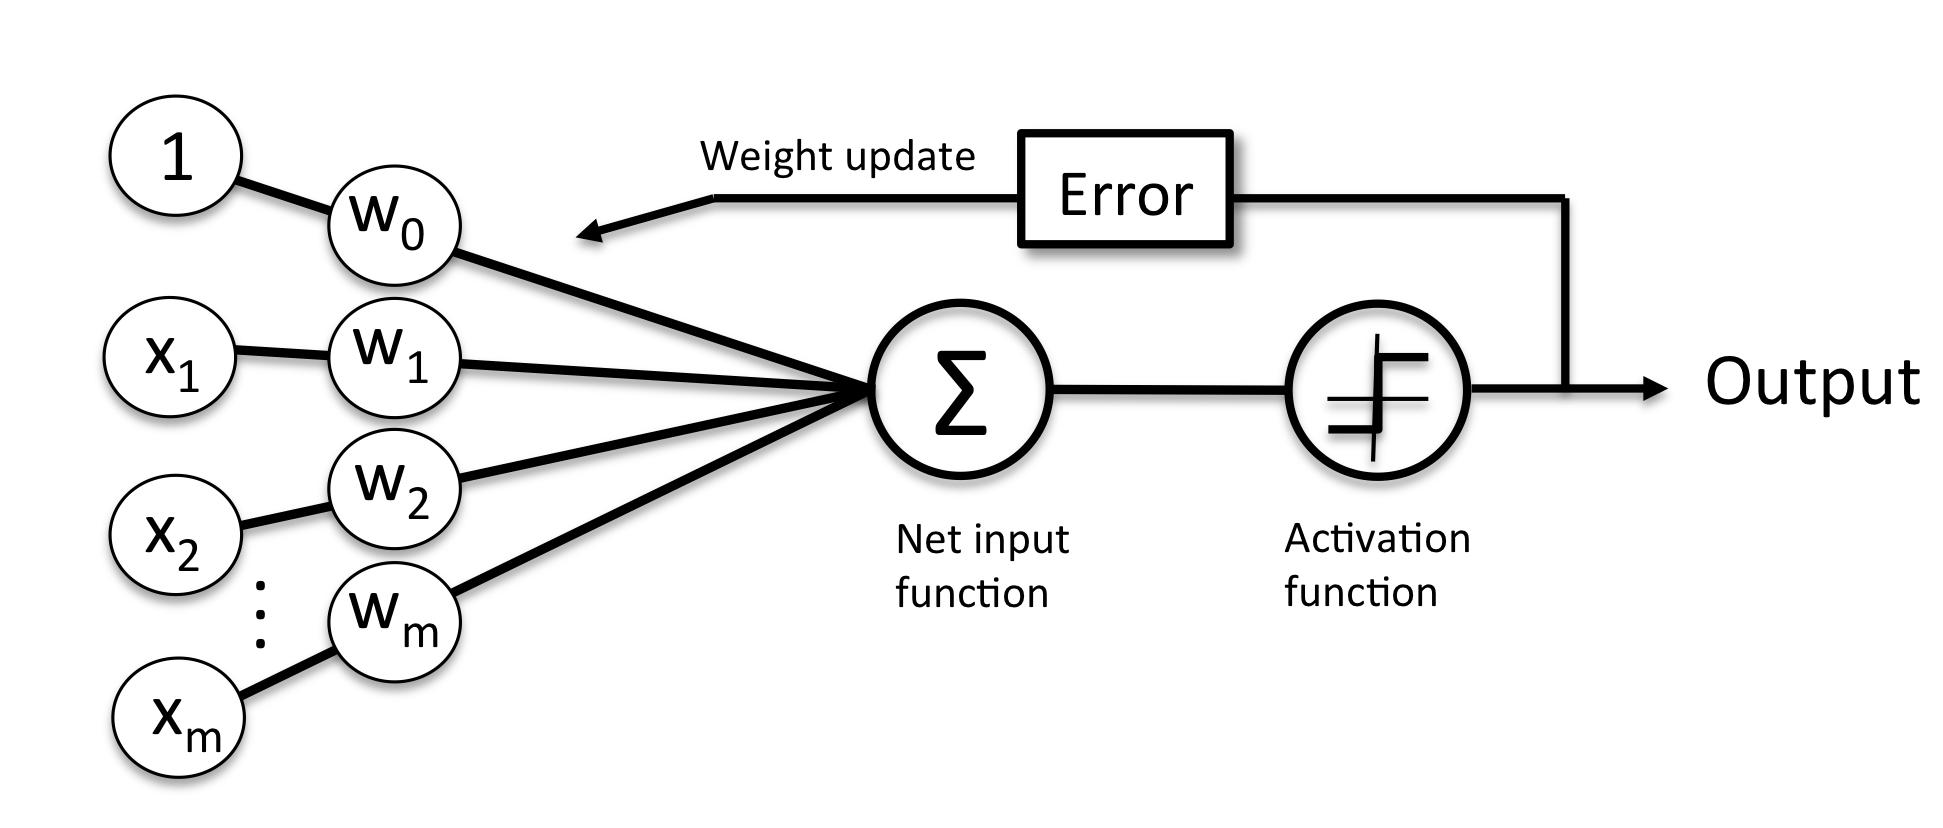

In [6]:
 Image(filename='./images/02_04.png', width=600) 

<br>
<br>

# Implementing a perceptron learning algorithm in Python

In [7]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### Additional Note (1)

Please note that the learning rate η (eta) only has an effect on the classification outcome  if the weights are initialized to non-zero values. If all the weights are initialized to 0, the learning rate parameter eta affects only the scale of the weight vector but not its direction. To have the learning rate influence the classification outcome, the weights need to be initialized to non-zero values. The respective lines in the code that need to be changed to accomplish that are highlighted on below:

```python
   def __init__(self, eta=0.01, n_iter=50, random_seed=1): # add random_seed=1
        ...
        self.random_seed = random_seed # add this line

    def fit(self, X, y):
        ...
        # self.w_ = np.zeros(1 + X.shape[1]) ## remove this line
        rgen = np.random.RandomState(self.random_seed) # add this line
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # add this line
```

### Additional Note (2)

I received a note by a reader who asked about the net input function:

>On page 27, you describe the code.

> the net_input method simply calculates the vector product wTx
However, there is more than a simple vector product in the code:

> def net_input(self, X):  
    """Calculate net input"""  
    return np.dot(X, self.w_[1:]) + self.w_[0]  
   
> In addition to the dot product, there is an addition. The text does not mention anything about what is this + self.w_[0]
> Can you (or anyone) explain why that's there?

-------

Sorry that I went over that so briefly. The `self.w_[0]` is basically the "threshold" or so-called "bias unit." I simply included the bias unit in the weight vector, which makes the math part easier, but on the other hand, it may make the code more confusing as you mentioned.



Let's say we have a 3x2 dimensional dataset `X` (3 training samples with 2 features). Also, let's just assume we have a weight `2` for feature 1 and a weight `3` for feature 2, and we set the bias unit to `4`. 

```
import numpy as np
>>> bias = 4.
>>> X = np.array([[2., 3.], 
...              [4., 5.], 
...              [6., 7.]])
>>> w = np.array([bias, 2., 3.])
```

In order to match the mathematical notation, we would have to add a vector of 1s to compute the dot-product:

```
>>> ones = np.ones((X.shape[0], 1))
>>> X_with1 = np.hstack((ones, X))
>>> X_with1
>>> np.dot(X_with1, w)
array([ 17.,  27.,  37.])
```

However, I thought that adding a vector of 1s to the training array each time we want to make a prediction would be fairly inefficient. So, instead, we can just "add" the bias unit (`w[0]`) to the do product (it's equivalent, since `1.0 * w_0 = w_0`:

```
>>> np.dot(X, w[1:]) + w[0] 
array([ 17.,  27.,  37.])
```

Maybe it is helpful to walk through the matrix-vector multiplication by hand. E.g.,

```
| 1  2  3 |   | 4 |   | 1*4 + 2*2 + 3*3 |   | 17 |
| 1  4  5 | x | 2 | = | 1*4 + 4*2 + 5*3 | = | 27 |
| 1  6  7 |   | 3 |   | 1*4 + 6*2 + 7*3 |   | 37 |
```

which is the same as

```
| 2  3 |                  | 2*2 + 3*3 |          | 13 + bias |   | 17 |
| 4  5 | x | 2 | + bias = | 4*2 + 5*3 | + bias = | 23 + bias | = | 27 |
| 6  7 |   | 3 |          | 6*2 + 7*3 |          | 33 + bias |   | 37 |

```

### Additional Note (3)

For simplicity at this point, we don't talk about shuffling at this point; I wanted to introduce concepts incrementally so that it's not too overwhelming all at once. Since a reader asked me about this, I wanted to add a note about shuffling, which you may want to use if you are using a Perceptron in practice. I borrowed the code from the `AdalineSGD` section below to modify the Perceptron algorithm accordingly (new lines are marked by trailing "`# new`" inline comment):

```python
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=10,
                 shuffle=True, random_state=None):  # new
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle  # new
        if random_state:  # new
            np.random.seed(random_state)  # new

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            if self.shuffle:  # new
                X, y = self._shuffle(X, y)  # new
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def _shuffle(self, X, y):  # new
        """Shuffle training data"""  # new
        r = np.random.permutation(len(y))  # new
        return X[r], y[r]  # new

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)
```

<br>
<br>

## Training a perceptron model on the Iris dataset

...

### Reading-in the Iris data

In [8]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


<hr>

### Note:


If the link to the Iris dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/iris/iris.data](./../datasets/iris/iris.data).

Or you could fetch it via

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


<hr>

<br>
<br>

### Plotting the Iris data

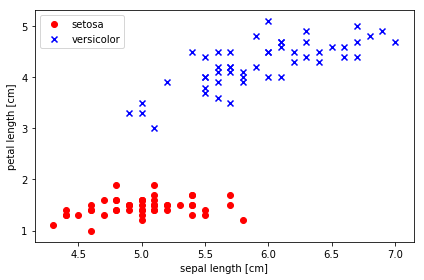

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./images/02_06.png', dpi=300)
plt.show()

<br>
<br>

### Training the perceptron model

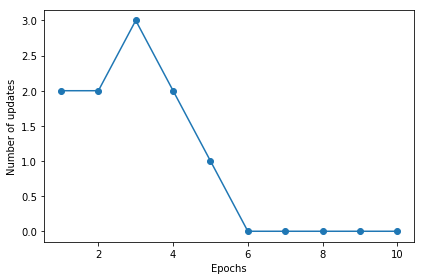

In [11]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.tight_layout()
# plt.savefig('./perceptron_1.png', dpi=300)
plt.show()

<br>
<br>

### A function for plotting decision regions

In [12]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

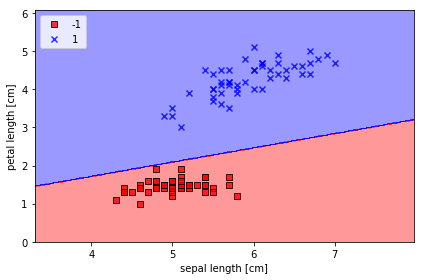

In [13]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./perceptron_2.png', dpi=300)
plt.show()

#### Additional Note (3)

The `plt.scatter` function in the `plot_decision_regions` plot may raise errors if you have matplotlib <= 1.5.0 installed if you use this function to plot more than 4 classes as a reader pointed out: "[...] if there are four items to be displayed as the RGBA tuple is mis-interpreted as a list of colours".

```python
plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
            alpha=0.8, c=cmap(idx),
            marker=markers[idx], label=cl)
```


To address this problem in older matplotlib versions, you can replace `c=cmap(idx)` by `c=colors[idx]`.

<br>
<br>

# Adaptive linear neurons and the convergence of learning

...

## Minimizing cost functions with gradient descent

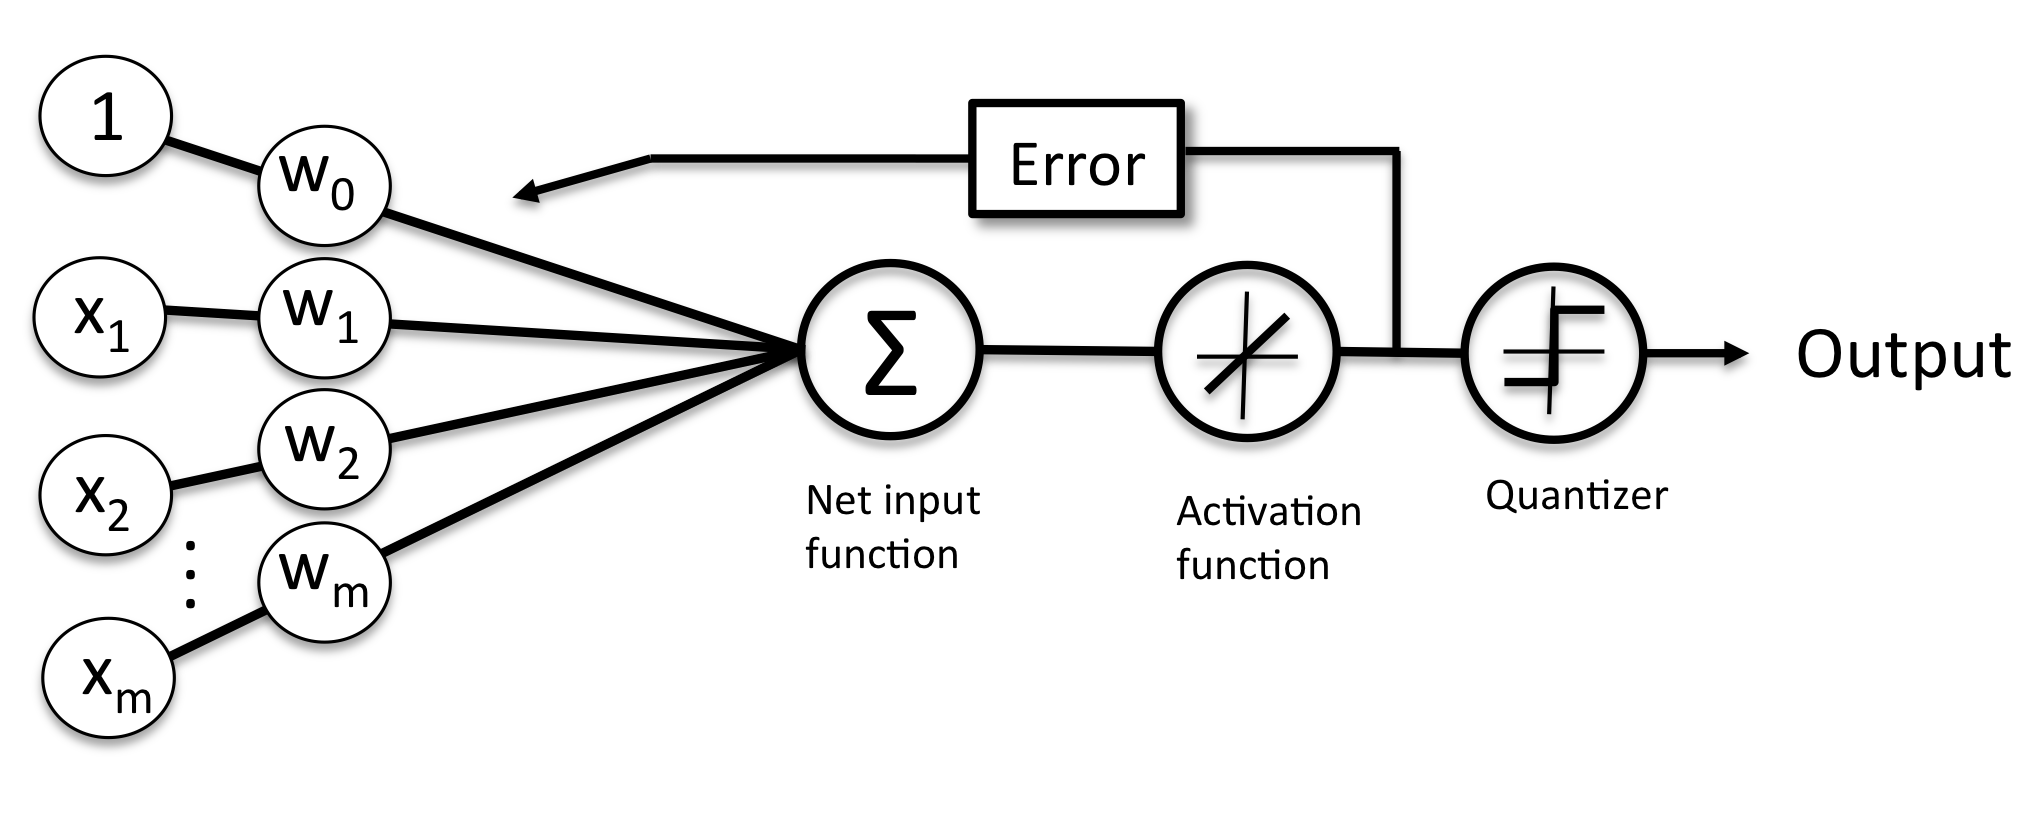

In [14]:
 Image(filename='./images/02_09.png', width=600) 

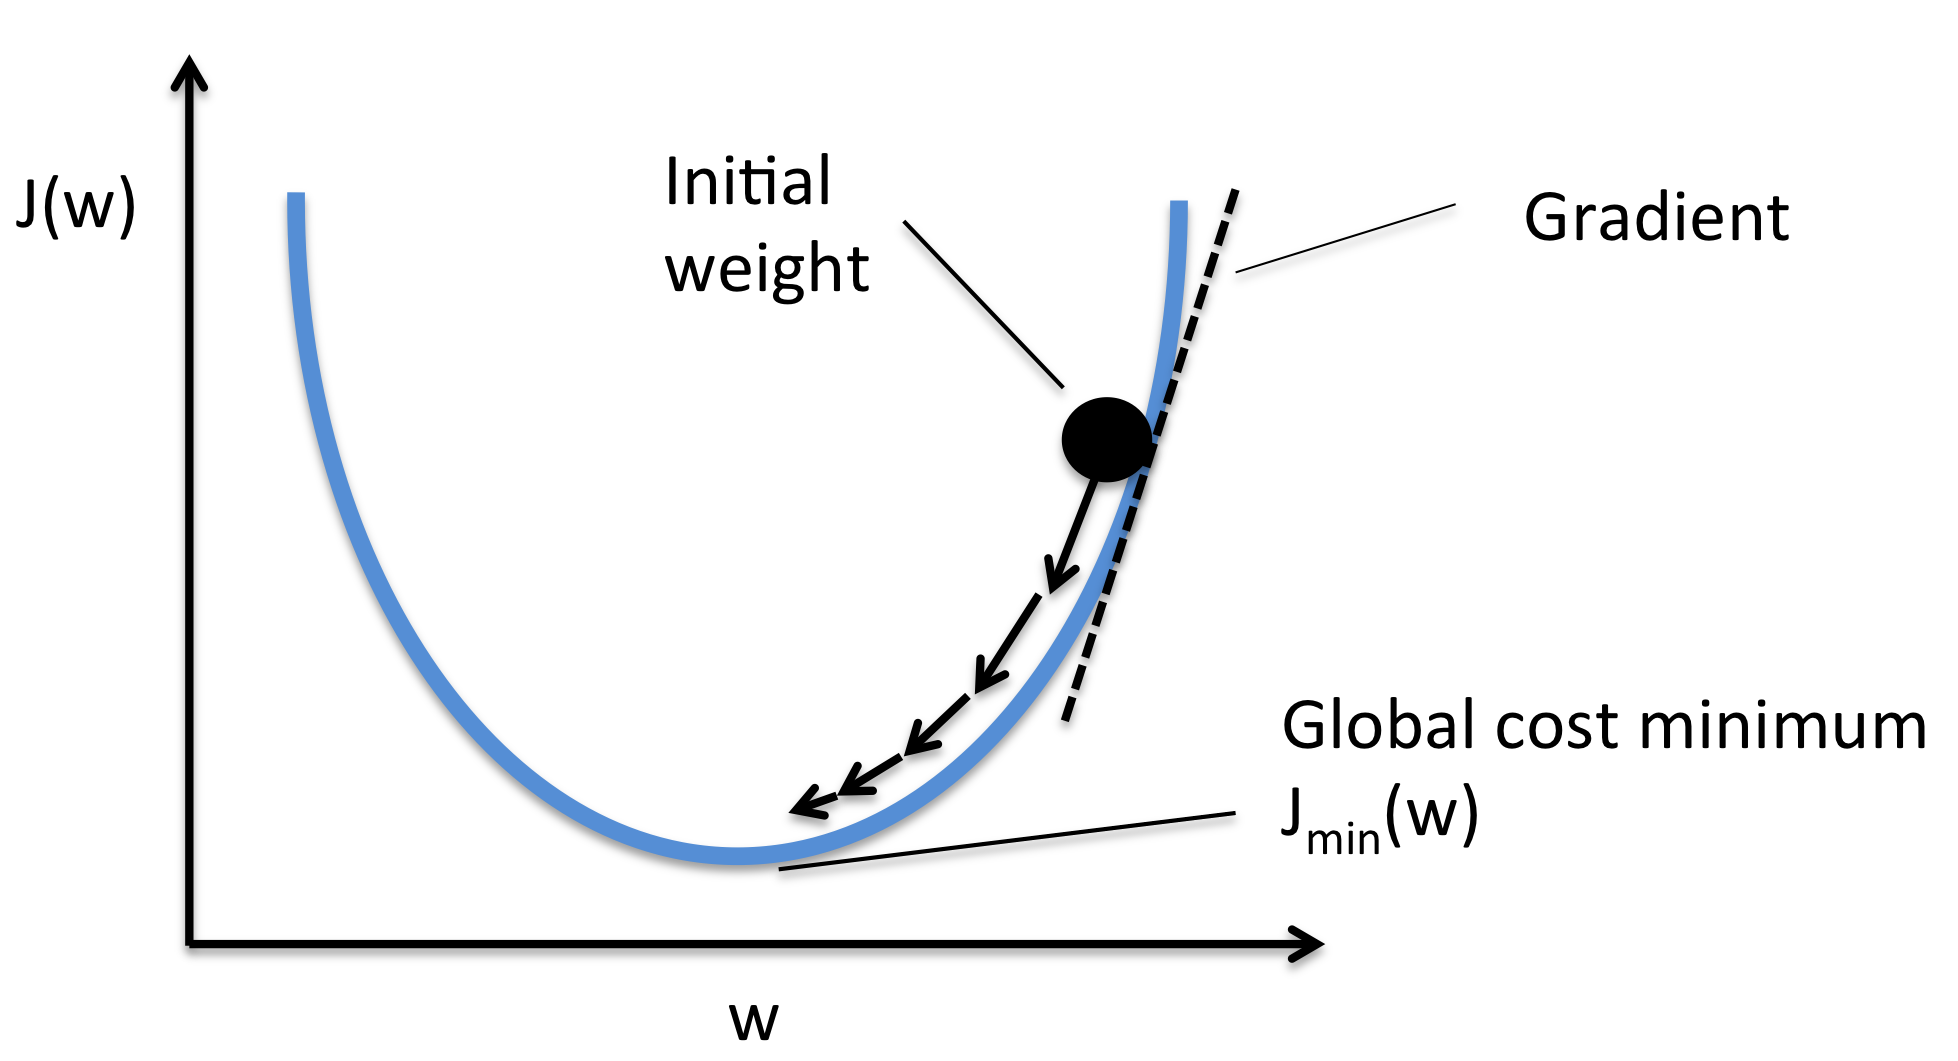

In [15]:
 Image(filename='./images/02_10.png', width=500) 

<br>
<br>

## Implementing an adaptive linear neuron in Python

In [16]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression, we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

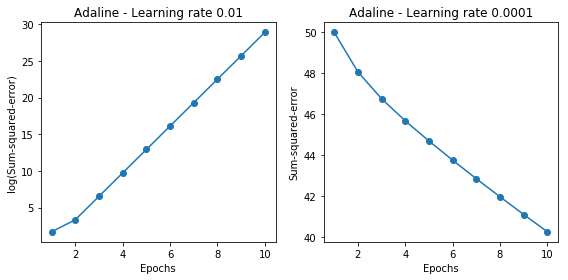

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
# plt.savefig('./adaline_1.png', dpi=300)
plt.show()

<br>
<br>

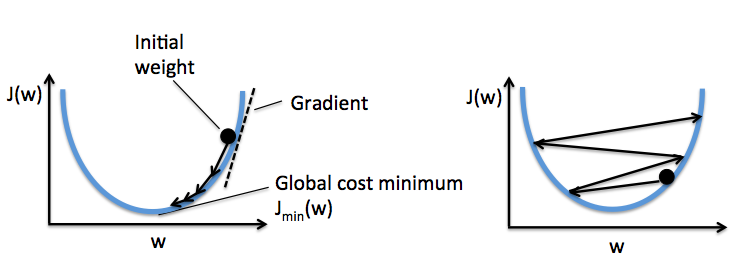

In [18]:
Image(filename='./images/02_12.png', width=700) 

<br>
<br>

In [19]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

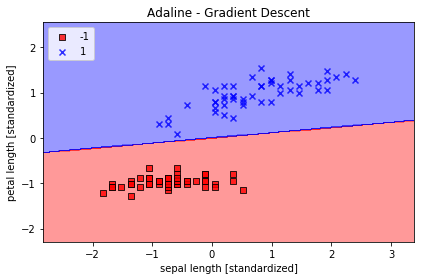

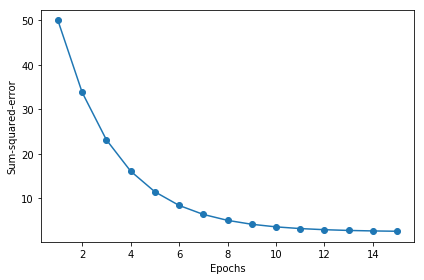

In [20]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./adaline_2.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()

<br>
<br>

## Large scale machine learning and stochastic gradient descent

In [21]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

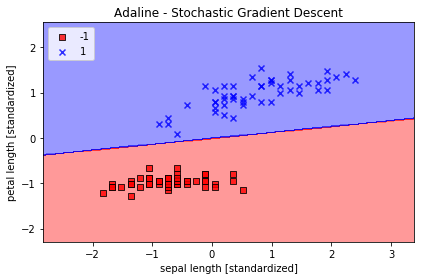

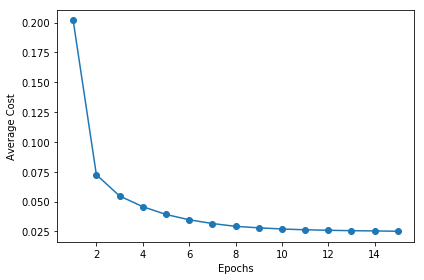

In [22]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./adaline_4.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('./adaline_5.png', dpi=300)
plt.show()

In [23]:
ada.partial_fit(X_std[0, :], y[0])

<br>
<br>

# Summary

...

# Appendix

The code below (not in the book) is a simplified, example implementation of a logistic regression classifier trained via gradient descent. The AdalineGD classifier was used as template and I commented the respective lines that were changed to turn it into a logistic regression classifier (as briefly mentioned in the "logistic regression" sections of Chapter 3).

In [24]:
class LogisticRegressionGD(object):
    """Logistic regression classifier via gradient descent.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        # We use the more common convention for logistic
        # regression returning class labels 0 and 1
        # instead of -1 and 1. Also, the threshold then
        # changes from 0.0 to 0.5 
        return np.where(self.activation(X) >= 0.5, 1, 0)
    
    # The Content of `activation` changed 
    # from linear (Adaline) to sigmoid.
    # Note that this method is now returning the
    # probability of the positive class
    # also "predict_proba" in scikit-learn
    def activation(self, X):
        """ Compute sigmoid activation."""
        z = self.net_input(X)
        sigmoid = 1.0 / (1.0 + np.exp(-z))
        return sigmoid

In [25]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:100, [0, 2]], iris.target[:100]

X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

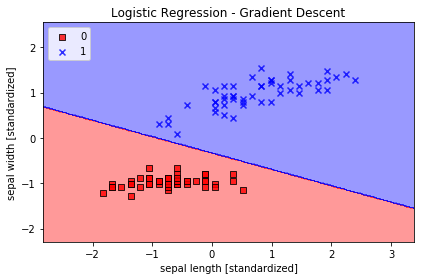

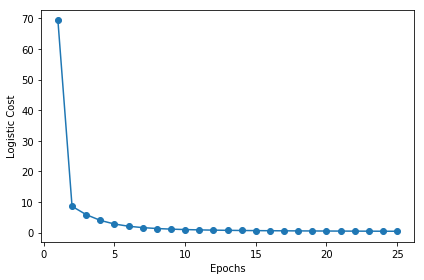

In [26]:
lr = LogisticRegressionGD(n_iter=25, eta=0.15)
lr.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=lr)
plt.title('Logistic Regression - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('sepal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

plt.plot(range(1, len(lr.cost_) + 1), lr.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Logistic Cost')

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()